# Pytorch starter - FasterRCNN Train

You can find the [inference notebook here](https://kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-inference)

- FasterRCNN from torchvision
- Uses Resnet50 backbone
- Albumentation enabled (flip + shift-scale-rotate)
- Original Dicom Images (resized by faster-rcnn)
- No validation yet

I trained the latest version (LB: 0.91) on my local machine; the settings were the same as in this notebook (v12).

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


1.12.1.post201
0.13.0a0+8069656
True


# convert_to_coco

In [4]:
# split_data.py

from glob import glob
import shutil
import os
import random

"""f = open("C:/A/lesionData/data_path.txt", 'r')
datapath = f.readline()[:-1]
f.close()"""

load_dir = '/home/ubuntu/lesionData/data'
save_dir = '/home/ubuntu/lesionData/data_split'

files = glob('%s/train/*.json' % load_dir)
random.shuffle(files)

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

shutil.copyfile('%s/class_id_info.csv' % load_dir, "%s/class_id_info.csv" % save_dir)
shutil.copyfile('%s/sample_submission.csv' % load_dir, "%s/sample_submission.csv" % save_dir)
shutil.copytree("%s/test" % load_dir, "%s/test" % save_dir)

num_all = len(files)
num_valid = round(0.1 * num_all)

ind = 0
for file in files:
    if ind < num_all - num_valid:
        shutil.copyfile(file, "%s/train/%s" % (save_dir, os.path.basename(file)))
    else:
        shutil.copyfile(file, "%s/valid/%s" % (save_dir, os.path.basename(file)))
    ind += 1
    

In [100]:
# convert_to_coco.py
# basic setup
import numpy as np
import json
import base64
import os
import random
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

from collections import defaultdict

base_dir = '/home/ubuntu/lesionData/data_split'
save_dir = "/home/ubuntu/lesionData/data_coco"

def convert_to_coco(
    json_paths, # 변경
    save_path,
    save_folder,
):
    """
        only for train dataset
    """
    res = defaultdict(list)
    # 제거
    # json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)

        # [추가] train image 저장
        image = BytesIO(base64.b64decode(tmp['imageData']))
        image = Image.open(image).convert('RGB')
        
        image.save(os.path.join(save_dir, save_folder, tmp['file_name'].split(".")[0]+".jpg"))
        
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'].split(".")[0]+".jpg", # 변경
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points']) # 추가
            x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, x2, y2],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)
        
save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
    
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

    
random.seed(10)

train_file = glob(os.path.join(base_dir, 'train/*.json'))
valid_file = glob(os.path.join(base_dir, 'valid/*.json'))

convert_to_coco(train_file, os.path.join(save_dir, 'train_annotations.json'), 'train')
convert_to_coco(valid_file, os.path.join(save_dir, 'valid_annotations.json'), 'valid')


##################################test################################################
test_files = sorted(glob(os.path.join(base_dir, 'test/*')))


test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))
        
save_path_dir = os.path.join(save_dir, "test")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

for sample in tqdm(test_json_list):
    
    image_id = sample['file_name'].split(".")[0]
    image = BytesIO(base64.b64decode(sample['imageData']))
    image = Image.open(image).convert('RGB')
    
    image.save(os.path.join(save_dir,"test",image_id+".jpg"))




100%|██████████| 20874/20874 [03:11<00:00, 109.08it/s]


# train annotation.json

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = '/home/ubuntu/lesionData/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAILD = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'


In [2]:
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [3]:
import json

file_path = DIR_INPUT+"/train_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())

dict_keys(['images', 'annotations', 'categories'])


In [4]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))

56360
72205
4


In [5]:
import pandas as pd

train_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    id=dic['image_id']
    train_dic['image_id'].append(id)
    train_dic['class_id'].append(dic['category_id'])
    if train_dic['class_id'] == 1:
        train_dic['class_name'].append('01_ulcer')
    elif train_dic['class_id'] == 2:
        train_dic['class_name'].append('02_mass')
    elif train_dic['class_id'] == 3:
        train_dic['class_name'].append('04_lymph')
    else:
        train_dic['class_name'].append('05_bleeding')            
    train_dic['x_min'].append(round(dic['bbox'][0],1))
    train_dic['y_min'].append(round(dic['bbox'][1],1))
    train_dic['x_max'].append(round(dic['bbox'][2],1))
    train_dic['y_max'].append(round(dic['bbox'][3],1))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == id:
           train_dic['width'].append(dic2['width'])
           train_dic['height'].append(dic2['height'])
           train_dic['file_name'].append(dic2['file_name'])

    
    
train_df=pd.DataFrame(train_dic)    

72205it [09:05, 132.46it/s]


In [6]:
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.8,144.0,468.7,303.2,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4,166.7,213.7,377.8,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.1,87.5,319.0,199.0,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2,256.2,145.0,319.0,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4,319.5,432.5,433.9,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.7,389.4,369.0,542.5,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0,255.9,193.5,320.7,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3,97.4,412.6,305.8,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9,103.2,397.9,188.9,576,576,train_151345.jpg


In [7]:
# train_df 전체 데이터 정보 저장하기
train_df.to_csv(f'{DIR_INPUT}/train.csv')

In [8]:
train_df.fillna(0, inplace=True) # nan 을 0으로 바꾸고
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.8,144.0,468.7,303.2,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4,166.7,213.7,377.8,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.1,87.5,319.0,199.0,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2,256.2,145.0,319.0,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4,319.5,432.5,433.9,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.7,389.4,369.0,542.5,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0,255.9,193.5,320.7,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3,97.4,412.6,305.8,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9,103.2,397.9,188.9,576,576,train_151345.jpg


In [9]:
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)
len(train_df)

df Shape: (72205, 10)
No Of Classes: 4


72205

In [10]:
# train_df 전체 데이터 정보 불러오기
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv',index_col=0)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.8,144.0,468.7,303.2,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4,166.7,213.7,377.8,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.1,87.5,319.0,199.0,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2,256.2,145.0,319.0,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4,319.5,432.5,433.9,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.7,389.4,369.0,542.5,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0,255.9,193.5,320.7,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3,97.4,412.6,305.8,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9,103.2,397.9,188.9,576,576,train_151345.jpg


In [11]:
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)
len(train_df)

df Shape: (72205, 10)
No Of Classes: 4


72205

In [12]:
train_df["class_id"].value_counts()

1    35079
4    17569
3    10809
2     8748
Name: class_id, dtype: int64

In [13]:
# nunique()는 데이터에 고유값들의 수를 출력해주는 함수
train_df["class_id"].nunique()

4

# valid annotation.json

In [14]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = '/home/ubuntu/lesionData/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'

In [15]:
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [16]:
import json

file_path = DIR_INPUT+"/valid_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())

dict_keys(['images', 'annotations', 'categories'])


In [17]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))


6262
8013
4


In [18]:
import pandas as pd
# [{'id': 148662, 'width': 320, 'height': 320, 'file_name': 'train_148662.jpg'},

valid_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    id=dic['image_id']
    valid_dic['image_id'].append(id)
    valid_dic['class_id'].append(dic['category_id'])
    if valid_dic['class_id'] == 1:
        valid_dic['class_name'].append('01_ulcer')
    elif valid_dic['class_id'] == 2:
        valid_dic['class_name'].append('02_mass')
    elif valid_dic['class_id'] == 3:
        valid_dic['class_name'].append('04_lymph')
    else:
        valid_dic['class_name'].append('05_bleeding')            
    valid_dic['x_min'].append(round(dic['bbox'][0],0))
    valid_dic['y_min'].append(round(dic['bbox'][1],0))
    valid_dic['x_max'].append(round(dic['bbox'][2],0))
    valid_dic['y_max'].append(round(dic['bbox'][3],0))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == id:
           valid_dic['width'].append(dic2['width'])
           valid_dic['height'].append(dic2['height'])
           valid_dic['file_name'].append(dic2['file_name'])

    
    
valid_df=pd.DataFrame(valid_dic)    

8013it [00:05, 1380.14it/s]


In [19]:
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,148662,05_bleeding,2,206.0,88.0,269.0,152.0,320,320,train_148662.jpg
1,124857,05_bleeding,4,436.0,277.0,532.0,365.0,576,576,train_124857.jpg
2,153731,05_bleeding,1,307.0,309.0,407.0,390.0,576,576,train_153731.jpg
3,153731,05_bleeding,1,422.0,386.0,500.0,457.0,576,576,train_153731.jpg
4,109031,05_bleeding,1,192.0,58.0,258.0,136.0,320,320,train_109031.jpg
...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,91.0,90.0,131.0,121.0,320,320,train_142746.jpg
8009,134031,05_bleeding,3,142.0,163.0,230.0,225.0,576,576,train_134031.jpg
8010,131307,05_bleeding,1,243.0,33.0,476.0,219.0,576,576,train_131307.jpg
8011,120195,05_bleeding,1,88.0,82.0,242.0,238.0,576,576,train_120195.jpg


In [20]:
# valid_df 전체 데이터 정보 저장하기
valid_df.to_csv(f'{DIR_INPUT}/valid.csv')

In [21]:
# 14번 라벨 = NO FINGING : 누락된 데이터(NaN)을 채우고, (0,0,1,1) 로 바꿈 -> nan 그대로 들어가면 안되는 이유!!!
valid_df.fillna(0, inplace=True) # nan 을 0으로 바꾸고
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,148662,05_bleeding,2,206.0,88.0,269.0,152.0,320,320,train_148662.jpg
1,124857,05_bleeding,4,436.0,277.0,532.0,365.0,576,576,train_124857.jpg
2,153731,05_bleeding,1,307.0,309.0,407.0,390.0,576,576,train_153731.jpg
3,153731,05_bleeding,1,422.0,386.0,500.0,457.0,576,576,train_153731.jpg
4,109031,05_bleeding,1,192.0,58.0,258.0,136.0,320,320,train_109031.jpg
...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,91.0,90.0,131.0,121.0,320,320,train_142746.jpg
8009,134031,05_bleeding,3,142.0,163.0,230.0,225.0,576,576,train_134031.jpg
8010,131307,05_bleeding,1,243.0,33.0,476.0,219.0,576,576,train_131307.jpg
8011,120195,05_bleeding,1,88.0,82.0,242.0,238.0,576,576,train_120195.jpg


In [22]:
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class_id"].nunique()))
valid_df.sort_values(by='image_id').head(10)
len(valid_df)

df Shape: (8013, 10)
No Of Classes: 4


8013

In [23]:
# valid_df 전체 데이터 정보 불러오기
valid_df = pd.read_csv(f'{DIR_INPUT}/valid.csv',index_col=0)
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,148662,05_bleeding,2,206.0,88.0,269.0,152.0,320,320,train_148662.jpg
1,124857,05_bleeding,4,436.0,277.0,532.0,365.0,576,576,train_124857.jpg
2,153731,05_bleeding,1,307.0,309.0,407.0,390.0,576,576,train_153731.jpg
3,153731,05_bleeding,1,422.0,386.0,500.0,457.0,576,576,train_153731.jpg
4,109031,05_bleeding,1,192.0,58.0,258.0,136.0,320,320,train_109031.jpg
...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,91.0,90.0,131.0,121.0,320,320,train_142746.jpg
8009,134031,05_bleeding,3,142.0,163.0,230.0,225.0,576,576,train_134031.jpg
8010,131307,05_bleeding,1,243.0,33.0,476.0,219.0,576,576,train_131307.jpg
8011,120195,05_bleeding,1,88.0,82.0,242.0,238.0,576,576,train_120195.jpg


In [24]:
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class_id"].nunique()))
valid_df.sort_values(by='image_id').head(10)
len(valid_df)

df Shape: (8013, 10)
No Of Classes: 4


8013

In [25]:
valid_df["class_id"].value_counts()

1    3879
4    1929
3    1193
2    1012
Name: class_id, dtype: int64

In [26]:
# nunique()는 데이터에 고유값들의 수를 출력해주는 함수
valid_df["class_id"].nunique()

4

# Data preparation

In [27]:
'''
'01_ulcer': 1,
'02_mass': 2,
'04_lymph': 3,
'05_bleeding': 4
'''
def label_to_name(id):
    id = int(id)
    id = id-1

    if id == 0:
        return "01_ulcer"
    if id == 1:
        return "02_mass"
    if id == 2:
        return "04_lymph"
    if id == 3:
        return "05_bleeding"
    else:
        return str(id)

In [28]:
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.8,144.0,468.7,303.2,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4,166.7,213.7,377.8,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.1,87.5,319.0,199.0,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2,256.2,145.0,319.0,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4,319.5,432.5,433.9,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.7,389.4,369.0,542.5,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0,255.9,193.5,320.7,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3,97.4,412.6,305.8,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9,103.2,397.9,188.9,576,576,train_151345.jpg


In [71]:
# Clean
# bbox 1 
# 박스 넓이 1이하 삭제 -> bbox가 너무 작으면 오류 **** 해야한다고.. -> no finding 자연스래 삭제됨
# 작으면 못그린다..................

train_df['area'] = (train_df['x_max'] - train_df['x_min']) * (train_df['y_max'] - train_df['y_min'])
valid_df['area'] = (valid_df['x_max'] - valid_df['x_min']) * (valid_df['y_max'] - valid_df['y_min'])
train_df = train_df[train_df['area'] > 1]
valid_df = valid_df[valid_df['area'] > 1]


"""
# 0~14 클래스id 사용
train_df = train_df[(train_df['class_id'] > -1) & (train_df['class_id'] < 15)]
valid_df = valid_df[(valid_df['class_id'] > -1) & (valid_df['class_id'] < 15)]
"""

#train_df = train_df.drop(['area'], axis = 1)
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,123168,05_bleeding,2,270.8,144.0,468.7,303.2,576,576,train_123168.jpg,31505.68
1,123168,05_bleeding,1,51.4,166.7,213.7,377.8,576,576,train_123168.jpg,34261.53
2,101247,05_bleeding,1,245.1,87.5,319.0,199.0,320,320,train_101247.jpg,8239.85
3,101247,05_bleeding,1,41.2,256.2,145.0,319.0,320,320,train_101247.jpg,6518.64
4,161826,05_bleeding,4,311.4,319.5,432.5,433.9,576,576,train_161826.jpg,13853.84
...,...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.7,389.4,369.0,542.5,576,576,train_122215.jpg,26379.13
72201,131941,05_bleeding,3,110.0,255.9,193.5,320.7,576,576,train_131941.jpg,5410.80
72202,151345,05_bleeding,1,256.3,97.4,412.6,305.8,576,576,train_151345.jpg,32572.92
72203,151345,05_bleeding,1,308.9,103.2,397.9,188.9,576,576,train_151345.jpg,7627.30


In [72]:
valid_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name,area
0,148662,05_bleeding,2,206.0,88.0,269.0,152.0,320,320,train_148662.jpg,4032.0
1,124857,05_bleeding,4,436.0,277.0,532.0,365.0,576,576,train_124857.jpg,8448.0
2,153731,05_bleeding,1,307.0,309.0,407.0,390.0,576,576,train_153731.jpg,8100.0
3,153731,05_bleeding,1,422.0,386.0,500.0,457.0,576,576,train_153731.jpg,5538.0
4,109031,05_bleeding,1,192.0,58.0,258.0,136.0,320,320,train_109031.jpg,5148.0
...,...,...,...,...,...,...,...,...,...,...,...
8008,142746,05_bleeding,3,91.0,90.0,131.0,121.0,320,320,train_142746.jpg,1240.0
8009,134031,05_bleeding,3,142.0,163.0,230.0,225.0,576,576,train_134031.jpg,5456.0
8010,131307,05_bleeding,1,243.0,33.0,476.0,219.0,576,576,train_131307.jpg,43338.0
8011,120195,05_bleeding,1,88.0,82.0,242.0,238.0,576,576,train_120195.jpg,24024.0


# LesionDataset
 

In [30]:
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,file_name
0,123168,05_bleeding,2,270.8,144.0,468.7,303.2,576,576,train_123168.jpg
1,123168,05_bleeding,1,51.4,166.7,213.7,377.8,576,576,train_123168.jpg
2,101247,05_bleeding,1,245.1,87.5,319.0,199.0,320,320,train_101247.jpg
3,101247,05_bleeding,1,41.2,256.2,145.0,319.0,320,320,train_101247.jpg
4,161826,05_bleeding,4,311.4,319.5,432.5,433.9,576,576,train_161826.jpg
...,...,...,...,...,...,...,...,...,...,...
72200,122215,05_bleeding,1,196.7,389.4,369.0,542.5,576,576,train_122215.jpg
72201,131941,05_bleeding,3,110.0,255.9,193.5,320.7,576,576,train_131941.jpg
72202,151345,05_bleeding,1,256.3,97.4,412.6,305.8,576,576,train_151345.jpg
72203,151345,05_bleeding,1,308.9,103.2,397.9,188.9,576,576,train_151345.jpg


In [44]:
class LesionDataset(Dataset):
    # 초기화
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    # 인덱스를 인자로 받아 훈련(혹은, 검증)에서 사용할 샘플 데이터 튜플을 반환하는 메소드
    # 샘플과 레이블(정수인덱스)로 이루어진 아이템 반환
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        
        #image_type=self.image_dir.split('/')[-1]
        #image_id = str(image_id)
        
        img_dir = self.image_dir
        img_fn = records['file_name'][0]

        image = Image.open(img_dir+'/'+img_fn).convert('RGB')
        print(type(image))
        image.show()
        #image = Image.open('/home/ubuntu/lesionData/data_coco'+'/'+image_type+'/'+image_type+'_'+image_id+'.jpg').convert('RGB')

        """
        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        # pixel_array
        image = dicom.pixel_array
        
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
        
        # Rescale Intercept
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        # Rescale Slope
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        """
        
        # image는 np.array입니다. 물론 height, width, layer로 되어 있는 조금 복잡한 구조
        # 따라서 이 np.array를 변환하면, 이미지 또한 변합니다. 
        # img.transpose(1, 0, 2)는 원래 height, width, layer -> width, height, layer
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        #image = image.transpose(2,1,0)

        if records.loc[0, "class_id"] == 0:
            records = records.loc[[0], :]
        
        # bounding box
        # values -> dataframe to array
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # label
        labels = torch.tensor(records["class_id"].values, dtype=torch.int64)
        print('1',boxes[:])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        print('14',boxes[:])
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        print('4',target['boxes'])

        # 이미지를 파이토치 텐서로 변환 torchvision.transforms
        # img 뿐만 아니라 bounding box, label 모두 tensor 형태로 바꿔야 한다.
        if self.transforms :

            # image, bboxes라는 key값 자체가 있기 때문에 반드시 이름을 이와 같게 해야 한다.
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            print('5',target['boxes'])
            print('56',sample['bboxes'])
            
            sample = self.transforms(**sample)
            print('6',sample['bboxes'])
            image = sample['image']    
            target['boxes'] = torch.tensor(sample['bboxes'])
            print('2',target['boxes'])

        if target["boxes"].shape[0] == 0:
            # Albumentation cuts the target (class 14, 1x1px in the corner)
            target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
            target["area"] = torch.tensor([1.0], dtype=torch.float32)
            target["labels"] = torch.tensor([0], dtype=torch.int64)
            
        print('3',target['boxes'])

        return image, target, image_ids
    # 데이터셋의 아이템수
    def __len__(self):
        return self.image_ids.shape[0]

# albumentations

In [63]:
# Albumentations
# format = pascal_voc:어느 데이터셋에 대한 bbox 내용을 가져올 것인지
# label_fields : 우리가 만든 labels
def get_train_transform():
    print('7')
    return A.Compose([
        #A.Flip(0.5),
        # shift, scale, rotate를 한번에 적용
        #A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        # 이미지의 maxsize를 max_size로 rescale합니다. aspect ratio는 유지합니다.
        #A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        # albumentations에서는 ToTensor 대신 ToTensorV2를 사용하는데 
        # ToTesorV2는 ToTensor와 마찬가지로 tensor형변환, channel dimension을 첫번째 차원으로 가져오는 역할을 하지만 min_max scaling은 하지 않는다는 것을 명심하자.
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format = 'pascal_voc',label_fields= ['labels']))

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Model

In [64]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [65]:
train_df["class_id"].nunique()

4

In [66]:
train_df["class_id"].value_counts()

1    35079
4    17569
3    10809
2     8748
Name: class_id, dtype: int64

* labels 에 대한 참고사항. 이 모델은 클래스 0 을 배경으로 취급합니다. 만약 준비한 데이터셋에 배경의 클래스가 없다면, labels 에도 0 이 없어야 합니다. 예를 들어, 고양이 와 강아지 의 오직 2개의 클래스만 분류한다고 가정하면, (0 이 아닌) 1 이 고양이 를, 2 가 강아지 를 나타내도록 정의해야 합니다. 따라서, 이 예시에서, 어떤 이미지에 두 개의 클래스를 모두 있다면, labels 텐서는 [1,2] 와 같은 식이 되어야 합니다.

In [67]:
# no finding 포함 5개 클래스
num_classes = 5

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [68]:
# batch sampler 로 묶인 이후에는, collate_fn을 호출해 batch로 묶는다.
def collate_fn(batch):
    return tuple(zip(*batch))
DIR_TRAIN = '/home/ubuntu/lesionData/data_coco/train'
DIR_VALID = '/home/ubuntu/lesionData/data_coco/valid'
train_dataset = LesionDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = LesionDataset(valid_df, DIR_VALID, get_valid_transform())


# Returns a random permutation of integers from 0 to n - 1.
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

7


In [69]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sample

<class 'PIL.Image.Image'>


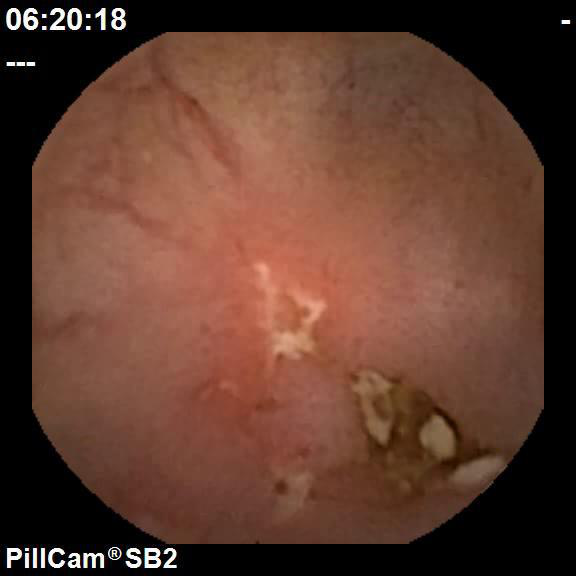

1 [[151.6 217.8 350.1 414.1]
 [209.9 401.7 356.7 538.2]]
14 [[151.6 217.8 350.1 414.1]
 [209.9 401.7 356.7 538.2]]
4 [[151.6 217.8 350.1 414.1]
 [209.9 401.7 356.7 538.2]]
5 [[151.6 217.8 350.1 414.1]
 [209.9 401.7 356.7 538.2]]
56 [[151.6 217.8 350.1 414.1]
 [209.9 401.7 356.7 538.2]]


ValueError: Expected y_min for bbox (0.26319444444444445, 72.60000000000001, 0.6078125000000001, 138.03333333333333, tensor(1)) to be in the range [0.0, 1.0], got 72.60000000000001.

In [70]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))

print('test')


images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3],3):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)



# Train

In [51]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

- model을 학습시키기 위해선 optimization라는 작업을 해준다. weight의 torch.backward()라는 함수로, gradient를 구해서 weight의 값을 변화시켜주는 역활을 한다. 가장 기본적인 방법으로 SGD가 있는데, 아래 나오는 모든 opimizer는 SGD의 응용이다.
- 우리가 data를 model에 입력했을 때, model은 그 data의 실제값과 model의 예측값을 비교하여 loss를 알려준다. SGD란 loss를 줄이기 위해 고안된 방법으로, loss의 미분을 이용하여 loss를 줄이는 것이 그 목표이다.
즉 우리는 gradient가 -가 되도록 값을 이동시키면 언젠가 최소값을 찾을 수 있다는 아이디어에서 출발한 것이 SGD이다.
- 여기서 lr은 Learning Rate의 줄임말이며, 미분값을 얼만큼 이동시킬 것인가를 결정한다. 초기값이 크다면 초반엔 loss값이 빠르게 줄겠지만, 나중에 가면 underfitting이 발생하게 된다.
- 하지만 sgd에도 단점이 있는데, 위의 그래프처럼 구하려는 함수의 미분 그래프가 2차함수가 아닌 3차 이상의 그래프일 경우 최소점이 2개 이상 생기는 경우가 발생한다.
- loss의 미분값이 파라미터의 값이 0에 존재한다고 생각해보자. 위의 사진을 보면, 우리가 구하려는 전역 최소값에 가기전, 지역 최소값에 도달하면 미분값이 0이 되면서 더 이상 움직이지 않는다. 그래서 sgd에 약간의 변형을 준 것이 SGD+Momentum이라는 개념이다.
- sgd에다가 이전의 이동값을 고려하도록 설계하여 momentum. 즉 관성을 주었다. 혹여 지역 최소값에 도달하더라도 앞으로 나아가서 지역 최소값을 탈출할 수 있도록 설정해준다.
- momentum값은 0.9에서 시작하며, 0.95, 0.99로 증가시키며 사용!


https://velog.io/@reversesky/Optimizer%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%A0%95%EB%A6%AC

In [52]:
# 모델에 사용되는 모든 입력 Tensor들에 대해 input = input.to(device) 을 호출해야 합니다.
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 10

In [31]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        # to 메소드를 활용해 gpu로 옮긴다. Data to GPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Label classification, BoundingBox Regression의 Loss 값이 Ditcionary 형태로 나온다.
        loss_dict = model(images, targets)

        # Dict 형태의 loss_dict에서 .values()로 key:values에서 values를 가져온다.
        losses = sum(loss for loss in loss_dict.values())
        
        # losses를 print해보면 tensor()로 감싸져 있다. .item()으로 숫자만 가져오자.
        loss_value = losses.item()

        # loss_hist에 loss_value를 저장한다.
        loss_hist.send(loss_value)

        # optimizer 업데이트
        optimizer.zero_grad() # 1. 기울기 0으로 초기화
        losses.backward()  # 2. 역전파
        optimizer.step() # 3. 업데이트

        # 10번마다 loss값 출력
        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_hist.value}")

        itr += 1
        
        # !!!REMOVE THIS!!!
        #break
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    print("Saving epoch's state...")
    torch.save(model.state_dict(), f"/home/ubuntu/data_dicom/weights/model_state_epoch_{epoch}.pth")

Iteration #100 loss: 0.7488957822692345
Epoch #0 loss: 0.7284422114839181
Saving epoch's state...
Iteration #200 loss: 0.6168863378983361
Epoch #1 loss: 0.6165623574567173
Saving epoch's state...
Iteration #300 loss: 0.6233460669496078
Epoch #2 loss: 0.6005586025735653
Saving epoch's state...
Iteration #400 loss: 0.5366048181712925
Epoch #3 loss: 0.5585844652549421
Saving epoch's state...
Iteration #500 loss: 0.4980970846160396
Iteration #600 loss: 0.5119158990554333
Epoch #4 loss: 0.5154717179235954
Saving epoch's state...
Iteration #700 loss: 0.5204099523986953
Epoch #5 loss: 0.49915988093333974
Saving epoch's state...
Iteration #800 loss: 0.49296403366027747
Epoch #6 loss: 0.49715260869199285
Saving epoch's state...
Iteration #900 loss: 0.5582106552830854
Epoch #7 loss: 0.4933171728677404
Saving epoch's state...
Iteration #1000 loss: 0.5311774069079167
Iteration #1100 loss: 0.48613264825302177
Epoch #8 loss: 0.4880759905921019
Saving epoch's state...
Iteration #1200 loss: 0.46501491

# valid

In [33]:
images, targets, image_ids = next(iter(valid_data_loader))

In [34]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [35]:
targets

[{'boxes': tensor([[ 597., 1507., 1891., 2141.],
          [ 603., 1341., 1928., 1980.],
          [ 600., 1482., 1956., 2035.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([4, 4, 4], device='cuda:0'),
  'image_id': tensor([45], device='cuda:0'),
  'area': tensor([820396., 846675., 749868.], device='cuda:0'),
  'iscrowd': tensor([0, 0, 0], device='cuda:0')},
 {'boxes': tensor([[0., 0., 1., 1.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([0], device='cuda:0'),
  'image_id': tensor([14], device='cuda:0'),
  'area': tensor([1.], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[0., 0., 1., 1.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([0], device='cuda:0'),
  'image_id': tensor([4], device='cuda:0'),
  'area': tensor([1.], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[0., 0., 1., 1.]], device='cuda:0', dtype=torch.float64),
  'labels': tensor([0], device='cuda:0'),
  'image

In [36]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
#permute() : 모든 차원의 순서를 재배치. 이렇게 바뀐 순서를 다시 원래대로 돌려주기 위해 permute함수가 사용된 것이다.
sample = images[0].permute(1,2,0).cpu().numpy()

In [37]:
# nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수라고 한다.
# .eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수인 셈이다.
# model.eval()의 역할은 약간 다르다. 현재(2019년) 시점에서는 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재한다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있다. BatchNorm같은 경우도 마찬가지다.
# 사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용된다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞다.

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [38]:
outputs[5]

{'boxes': tensor([[ 548.6559,  264.8406,  789.5708,  359.6841],
         [ 469.8084,  244.3405,  746.0526,  354.1381],
         [ 537.8614,  268.7436,  740.9654,  324.2870],
         [ 520.0261,  256.5819,  715.4523,  414.8188],
         [ 511.1500,  277.7285,  696.0507,  340.3727],
         [1073.8086,  227.4085, 1347.0481,  333.6952],
         [ 496.2679,  303.2518,  703.9446,  493.9299],
         [ 427.7991,  273.4562,  683.1193,  402.9449],
         [1496.5461, 1875.2787, 1677.3634, 2000.1436],
         [ 484.8865,  328.7908,  824.9387,  534.5633],
         [ 524.0261,  231.4305,  796.6733,  325.8520],
         [ 601.8304,  279.4659,  757.7796,  329.7262],
         [ 549.2692,  303.0759,  784.7354,  405.4013],
         [1143.4648,  196.8596, 1356.3030,  365.8703],
         [ 435.9104,  239.4219,  781.7705,  563.4241],
         [1025.4989,  293.7009, 1388.0033,  634.3474],
         [1081.0535,  286.5145, 1255.3734,  322.0147],
         [ 456.5672,  356.5136,  644.6656,  527.2050],
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


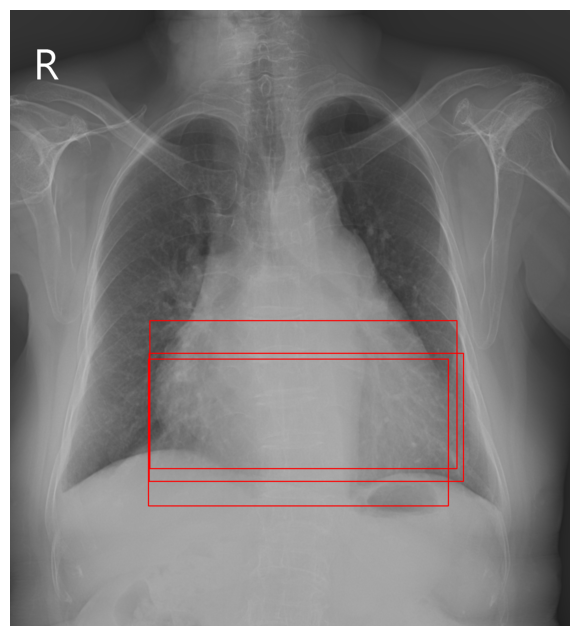

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)